In [1]:
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import time

Using TensorFlow backend.


In [21]:
# Load and transform training data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_norm = x_train/255
x_test_norm = x_test/255

# Convert labels to vectors
target_names=[
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
binarizer = LabelBinarizer()
y_test_binarized = binarizer.fit_transform(y_test)
y_train_binarized = binarizer.transform(y_train)

# Generate stream of training data
datagen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train_norm)

In [24]:
# Load model
model = load_model('cifar10.model')

In [3]:
# Create model
model = Sequential()


model.add(BatchNormalization(input_shape=x_train.shape[1:]))
# First conv layer
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(BatchNormalization())

# Second conv layer
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Third conv layer
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())

# FC layer
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
__________

In [ ]:
# Train model
batch_size = 32
history = model.fit_generator(datagen.flow(x_train_norm, y_train_binarized, batch_size=batch_size),
                              steps_per_epoch=len(x_train_norm)/batch_size,
                              epochs=80,
                              validation_data=(x_test_norm, y_test_binarized),
                              callbacks=[
                                  EarlyStopping(patience=5, verbose=1),
                                  ModelCheckpoint('cifar10.model', save_best_only=True, verbose=1)                              ])

In [25]:
# Show the classification report for testing  data
print(model.evaluate(x=x_test_norm, y=y_test_binarized))
probs = model.predict(x_test_norm)
preds = np.argmax(probs,axis=1)
print(classification_report(y_test, 
                      preds, 
                      target_names=target_names)
     )

10000/10000 [==============================] - 4s 374us/step
[0.26717611560821536, 0.9112]
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.89      0.89      0.89      1000
         cat       0.87      0.79      0.82      1000
        deer       0.90      0.92      0.91      1000
         dog       0.91      0.81      0.86      1000
        frog       0.87      0.97      0.92      1000
       horse       0.94      0.94      0.94      1000
        ship       0.95      0.95      0.95      1000
       truck       0.93      0.96      0.94      1000

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
# Plot the history of loss and val_loss during training
plt.plot(history.history['loss'], color='r', label='loss')
plt.plot(history.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.xticks(np.arange(20)*2)
plt.xlabel('epoch')
plt.ylabel('loss')

prediction: frog, truth: frog
149


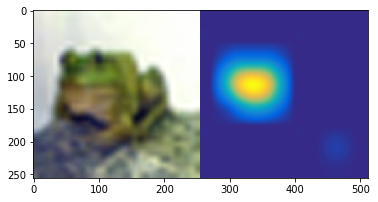

In [300]:
# Display sample image and classification
i = np.random.choice(np.arange(len(x_test)), size=1)[0]
input_img = np.expand_dims(x_test_norm[i], axis=0)
class_i = np.argmax(model.predict(input_img)[0])
class_name = target_names[class_i]
img = x_test[i]
img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
print('prediction: {}, truth: {}'.format(class_name, target_names[y_test[i][0]]))

# Display activation of a conv layer channel
intermediate_outputs = Model(
    inputs=model.inputs, 
    outputs=model.get_layer('conv2d_18').output)
outputs = intermediate_outputs.predict(input_img)
outputs = outputs[0,:,:,:]
biggest_activation = np.argmax(outputs.max(axis=0).max(axis=0))
out_max = outputs.flatten().max()
out_min = outputs.flatten().min()
output_img = outputs[:,:,biggest_activation]
output_img = 255*(output_img - out_min) / (out_max - out_min)
output_img = output_img.astype('uint8')
output_img = cv2.resize(output_img, (256, 256), interpolation=cv2.INTER_CUBIC)
output_img = cv2.applyColorMap(output_img, cv2.COLORMAP_PARULA  )
output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)

img = np.hstack([img, output_img])
plt.imshow(img)